# Multi-armed bandits

In this task you are going to implement ETC and UCB. Then you will play around the parameters in order to draw some more conclusion.

Outline:
* Simulator writing
* ETC and experiments
* UCB and experiments

## Bulding a simulator for the bandit

In [368]:
from matplotlib import pyplot as plt
import numpy as np  # we can use this library for working with matrices

In [369]:
class Bandit:
    def __init__(self, k, means, rounds):
        # we assume Gaussian distributions with sigma=1
        self.k = k  # number of arms
        self.means = means  # a list of means of rewards for each arm 
        self.rounds = rounds  # number of available rounds
      
        # ----- chose the optimal reward -----
        self.optimal_reward = 500
        self.counter = 0
        # gather the empirical/observed/experienced regret so far
        self.empirical_regret = 0
        self.emp_regrets = []
        # gather the expected regret so far
        self.expected_regret = 0
        self.exp_regrets = []
    
    def play_arm(self, arm):
        # ----- sample the appropriate reward -----
        reward = np.random.normal(self.means[arm], 1)  

        # ----- calculate the regret so far and save it -----
        # empirical regret
        self.empirical_regret = self.optimal_reward - reward
        self.emp_regrets.append(self.empirical_regret)
        # expected regret
        self.expected_regret = np.mean(self.emp_regrets)
        self.exp_regrets.append(self.expected_regret)
        # increase the counter
        self.counter = self.counter+1
        return reward
    
    def finished(self):
        # ----- return if there is no more round remained -----
        if self.rounds == 0:
          return 
    
    def plot_regret(self):
        plt.figure(figsize=(8, 6))
        plt.plot(list(range(self.counter)), self.emp_regrets, 'b+', list(range(self.counter)), self.exp_regrets, 'ro')
        plt.xlabel("iteration")
        plt.ylabel("regret")
        plt.grid()
        plt.show()

## ETC algorithm

In [370]:
class ETCsolver:
    def __init__(self, k, m, bandit):
        self.k = k  # number of arms
        self.m = m  # number of exploration rounds for each arm
        self.bandit = bandit 
        
        # ----- create a cache storing the number of trials and the average rewards -----
        # for each action
        self.cache = np.zeros((self.k, self.bandit.rounds))
    
    def _exploration_phase(self):
        self.counter = 0
        while self.counter < self.k * self.m :
            # ----- implement the exploration part -----
            # play the bandit and update cache
            arm = np.mod(self.counter, self.k)
            rewards = Bandit.play_arm(self.bandit, arm)
            self.cache[arm, self.counter] = rewards
            self.counter=self.counter+1
            self.bandit.rounds = self.bandit.rounds-1
    
    def _choose_best_action(self):
        # ----- we calculate the average reward of each arm -----
        # return the best arm

        avg_scores=[]
        for i in range(self.k):
          avg_reward = np.sum(self.cache[i])/self.m
          avg_scores.append(avg_reward)
       
        best_arm = avg_scores.index(max(avg_scores))
        return best_arm
    
    def run(self):
        self._exploration_phase()
        # after exploration we choose the best action
        optimal_arm = self._choose_best_action()

        # ----- play until finished -----
        if Bandit.finished(self.bandit)!=True:
          for i in range(self.bandit.rounds):
            Bandit.play_arm(self.bandit, optimal_arm)

    def get_regret(self):
        return self.bandit.regrets
    
    def best_action(self):
        return self._choose_best_action() + 1

In [371]:
def experiment_etc(k, mu, m, rounds):
    bandit = Bandit(k, mu, rounds)
    etc = ETCsolver(k, m, bandit)

    etc.run()
    etc.bandit.plot_regret()
    print("Optimal action: {}".format(etc.best_action()))

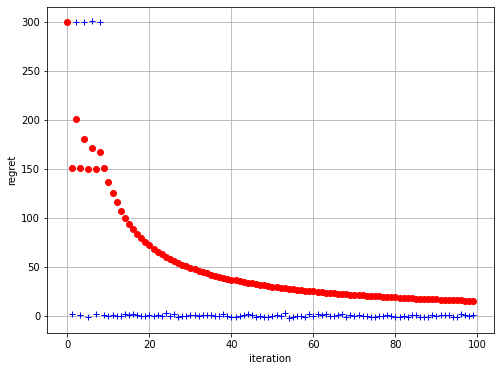

Optimal action: 2


In [372]:
# just for checking the results
experiment_etc(k=2, mu=[200, 500], m=5, rounds=100)

## UCB algorithm

In [344]:
class UCBsolver:
    def __init__(self, k, delta, bandit):
        self.k = k  # number of actions
        self.delta = delta  # error probability
        self.bandit = bandit

        self.cache = np.zeros((k, 2))  # stores the number and rewards so far
        self.actions = []
    

    def _init_phase(self):
        # at the very beginning each arm is equally good
        # unexplored arms are always the best
        # ----- pick each arm once to initialize the cache -----
        # we want to avoid division by zero
        for arm in range(self.k):
          self.cache[arm, -1] = self.bandit.optimal_reward
          self.cache[arm, 0] = 1
        return self.cache
            
           
    
    def _choose_best_action(self):
        # this implements the score for ucb

        # ----- first is the average reward term -----
        average_rewards = np.divide(np.sum(self.cache[:, 1:], axis=1).reshape(-1, 1), self.cache[:, 0].reshape(-1, 1))
        
        # select the best arm
        best_arm = (average_rewards + np.sqrt((2*np.log(1/self.delta)) / self.cache[:, 0].reshape(-1, 1))).argmax()

        return best_arm

    def run(self):
        self._init_phase()
        
        # ----- while not finished -----
        while self.bandit.rounds != 0:
          # ----- chooe optimal arm -----
          best_arm = self._choose_best_action()

          # ----- storing the actions so far -----
          self.actions.append(best_arm)

          # ----- playing the chosen arm ----
          reward = Bandit.play_arm(self.bandit, best_arm)

          # ----- update cache -----
          
          # insert the reward for all arms
          # this is going to insert for every arm the sampled reward
          self.cache = np.insert(self.cache, 1, reward, axis = 1)

          # 0 out the rewards for all the arms which are not the best arm
          for i in range(self.k):
            if i != best_arm:
              self.cache[i, 1] = 0
          
          # increase the number of times an arm is explored
          self.cache[best_arm, 0] = self.cache[best_arm, 0] + 1

          # reduce the rounds by 1
          self.bandit.rounds = self.bandit.rounds -1
          
          
    def plot_actions(self):
        plt.figure(figsize=(8, 7))
        plt.plot(list(range(len(self.actions))), self.actions, 'r+')
        plt.xlabel("iteration")
        plt.ylabel("chosen action")
        plt.grid()
        plt.show()

In [345]:
def experiment_ucb(k, mu, delta, rounds):
    bandit = Bandit(k, mu, rounds)
    ucb = UCBsolver(k, delta, bandit)

    ucb.run()
    ucb.bandit.plot_regret()
    ucb.plot_actions()

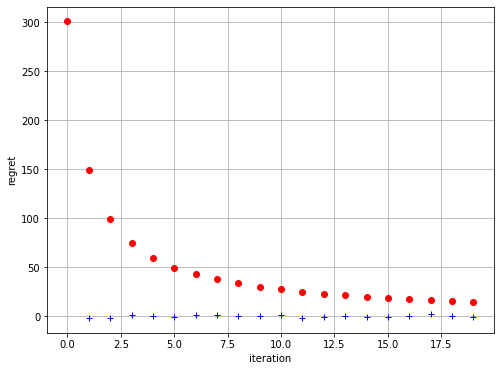

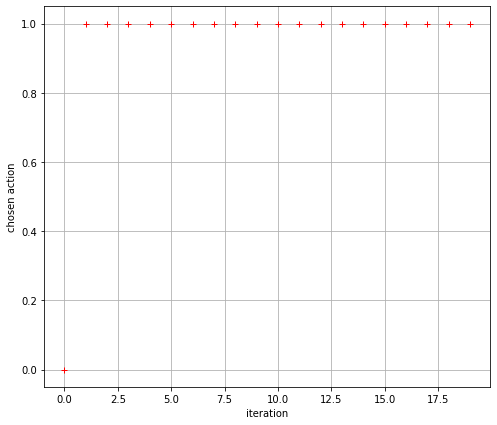

In [346]:
## just for checking the results
experiment_ucb(k=2, mu=[200, 500], delta=0.9, rounds=20)

## Experiments

### **Optimal Reward = 500**

We assumed gaussian distributions of rewards for arms with **sigma=1**. Sampled rewards are not going to deviate alot from the mean reward (about 68% of the sampled rewards are within one standard deviation away from the mean reward) and this will make it easy for the algorithms to find the best arm when differences in means are big.


Bad arms => Those arms where the arm's reward distribution's mean is significatly less than the optimal reward..

Good arms => Those arms where the arm's reward distribution's mean is close to the optimal reward. If regret goes negative then I am doing better than optimal reward (profit) but doing atleast close to optimal reward is enough as expected regret approaches 0.

**For use-cases i assume that the mean rewards of all arms are considerably less than the optimal reward. This means that no arm is going to give me 0 regret, its a fight for the arm that gives me smallest regret. Each arm will have a different mean (no repetitions)**

# ETC use-cases

#### Difference of 1 with 2 arms

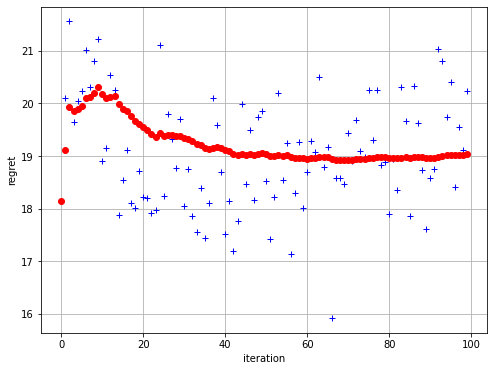

Optimal action: 2


In [347]:
# Try it with two arms and small difference between the mean values
# What are the required number of rounds to find the best action?
experiment_etc(k=2, mu=[480, 481], m=5, rounds=100)


With a small differnce it is necessary to explore each arm for atleast 5 times (10 rounds in total). Otherwise, if i dont explore much the algorithm may end up with commiting with the bad arm and gives inconsistant results (sometimes commits to arm1 sometimes to arm 2) which I dont want. 

Regrets for each arm during the exploration phase are so close that its difficult to tell which arm was explored just by looking at the regrets.


#### Difference of 10 with 2 arms

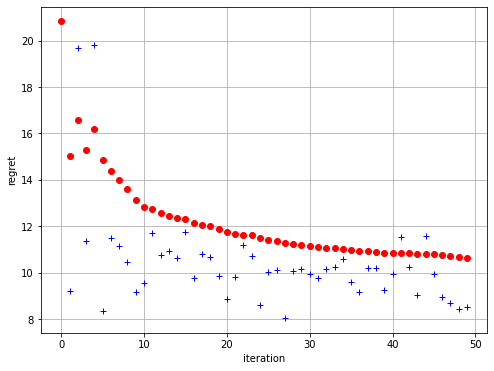

Optimal action: 2


In [348]:
# Try it with two arms and big difference between the mean values
# What are the required number of rounds to find the best action?
experiment_etc(k=2, mu=[480, 490], m=3, rounds=50)


In this senerio best arm is detected after 6 rounds. The algorithm can find the best arm even with exploring each arm once (totalling to 2 rounds), just to be sure i explored each arm 3 times and then it commits to the best arm and keep on sampling rewards until remaining rounds finish.

Regrets for each arm during the exploration phase are well seperated.

### Difference of 1 with 5 arms

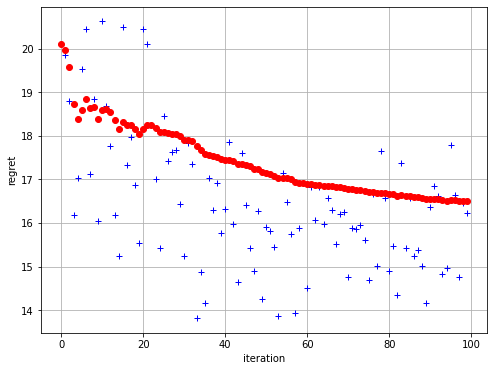

Optimal action: 5


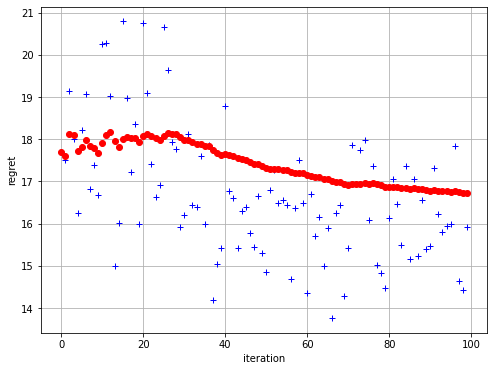

Optimal action: 5


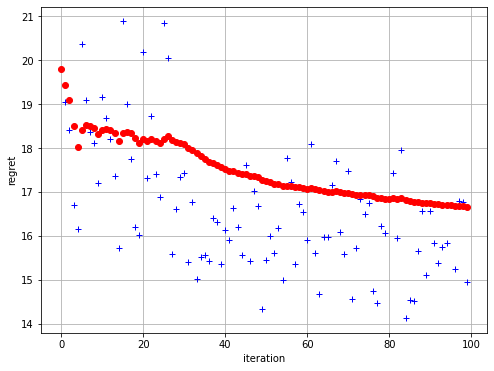

Optimal action: 5


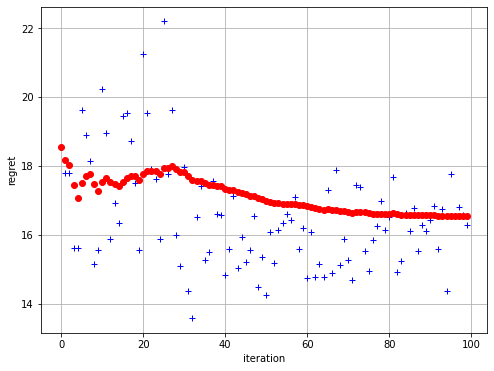

Optimal action: 5


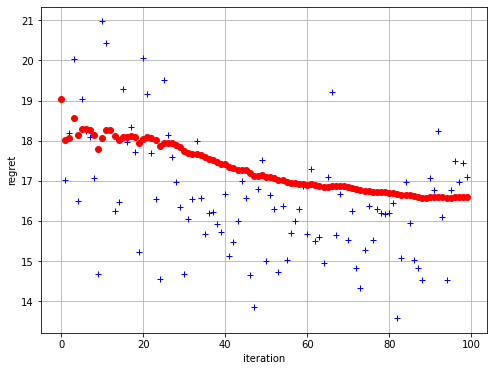

Optimal action: 5


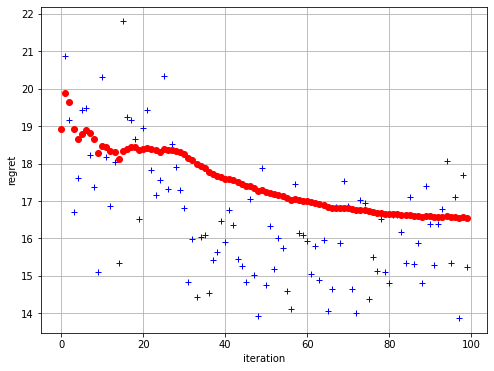

Optimal action: 5


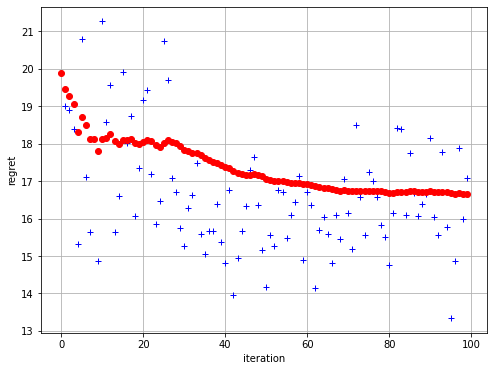

Optimal action: 5


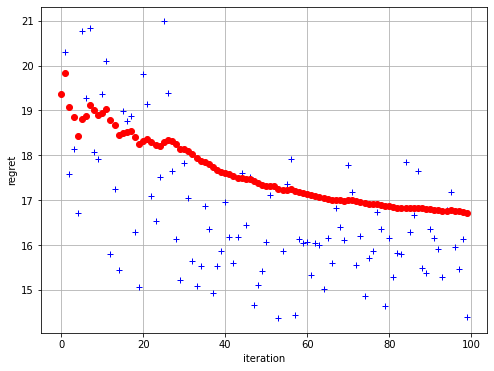

Optimal action: 5


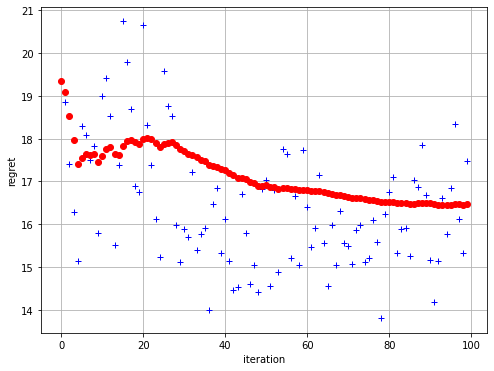

Optimal action: 5


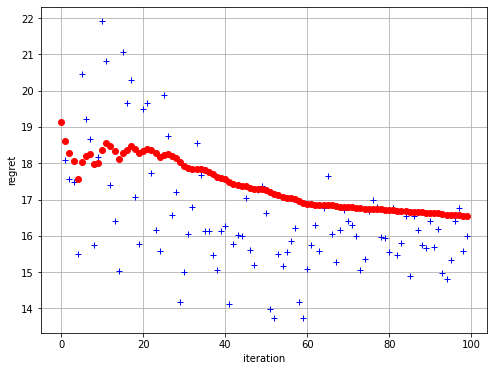

Optimal action: 5


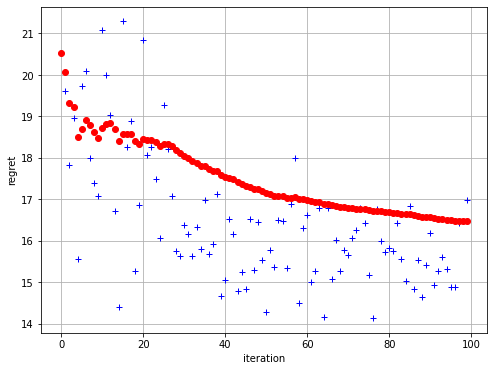

Optimal action: 5


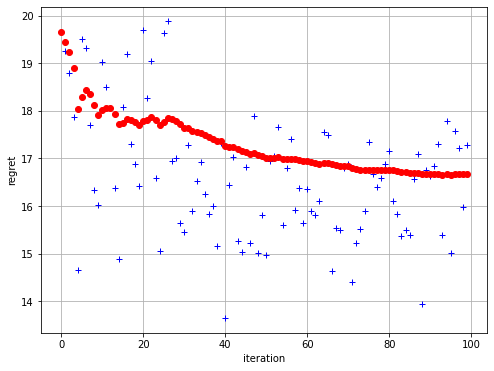

Optimal action: 5


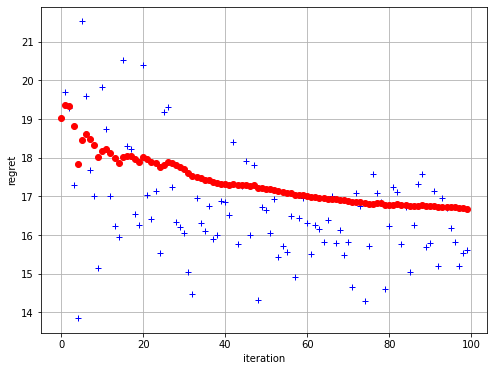

Optimal action: 5


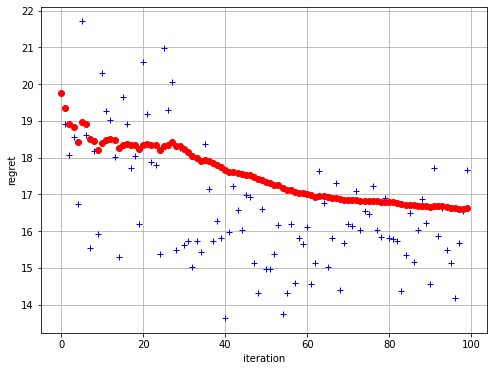

Optimal action: 5


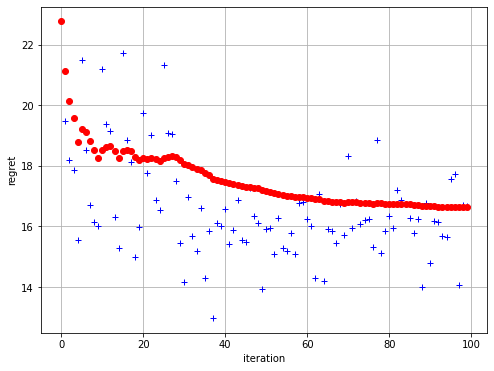

Optimal action: 5


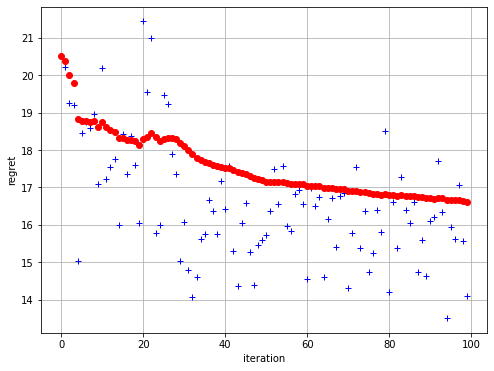

Optimal action: 5


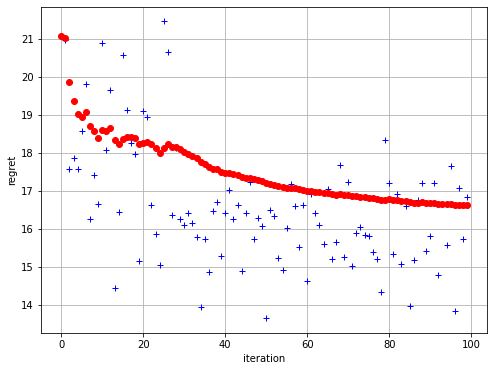

Optimal action: 5


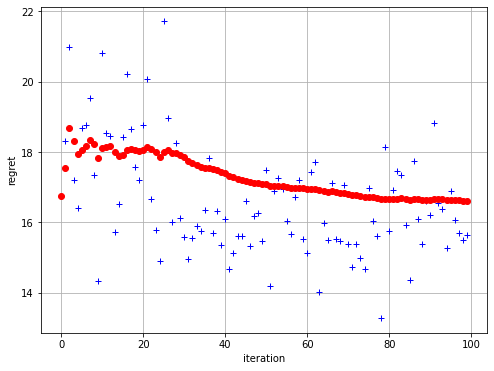

Optimal action: 5


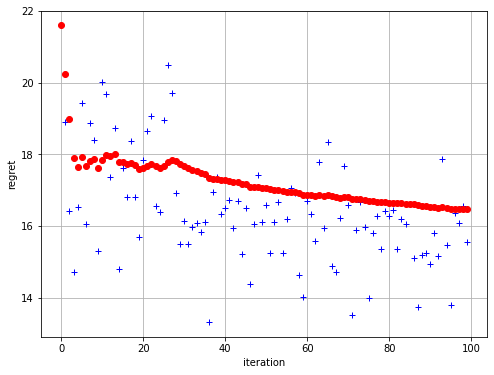

Optimal action: 5


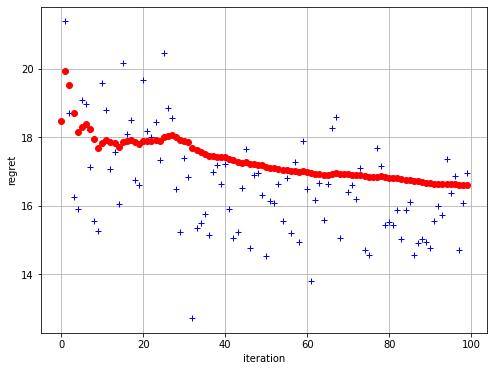

Optimal action: 5


In [349]:
# Try it with five arms and small differences among the mean values
# What are the required number of rounds to find the best action?
for i in range(20):
  experiment_etc(k=5, mu=[480, 481, 482, 483, 484], m=6, rounds=100)

The fight was mostly for 4th and 5th arm if i explored each arm for 4 or 5 times. I had to explore each arm atleast 6 times to get consistant results. So i need atleast 30 rounds in total to get the best arm and consistant results. To check the consistancy i ran the algorithm 20 times, if it's consistant then it should commit to the best arm in all of the 20 iterations. 

#### Difference of 1 with 50 arms

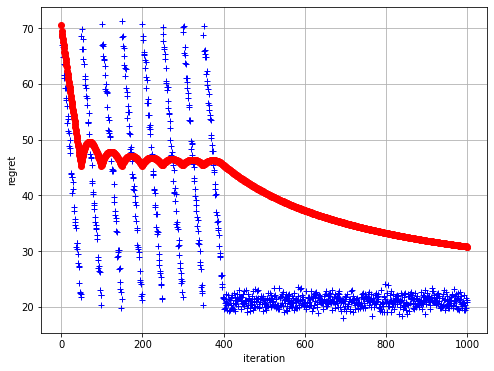

Optimal action: 50


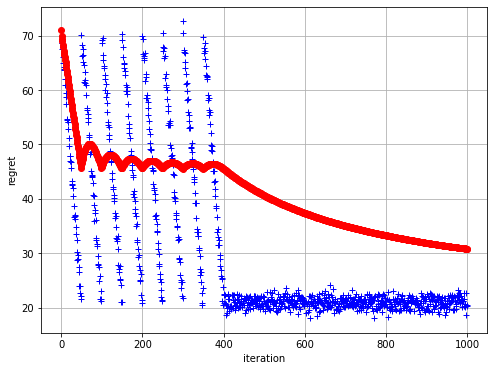

Optimal action: 50


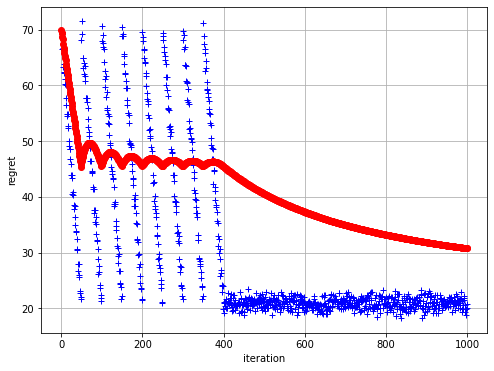

Optimal action: 50


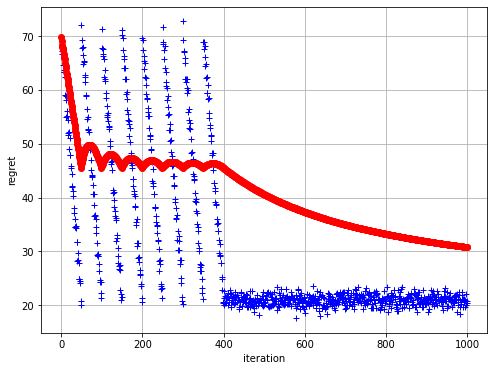

Optimal action: 50


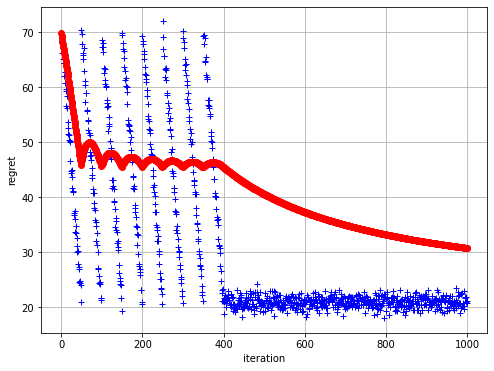

Optimal action: 50


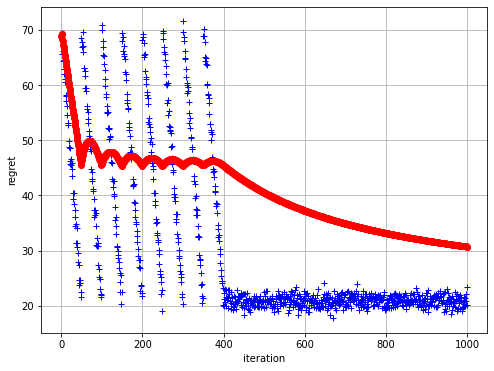

Optimal action: 50


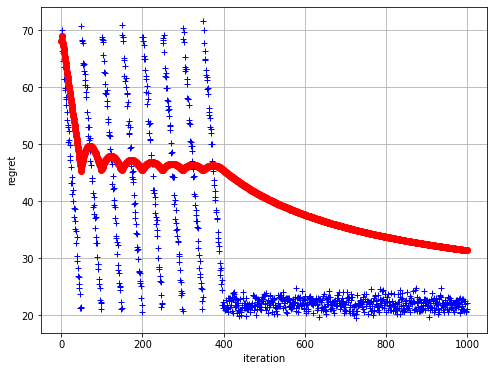

Optimal action: 49


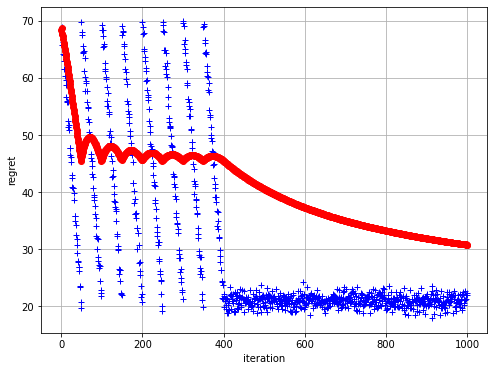

Optimal action: 50


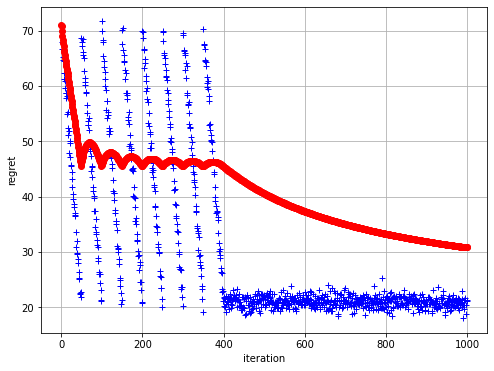

Optimal action: 50


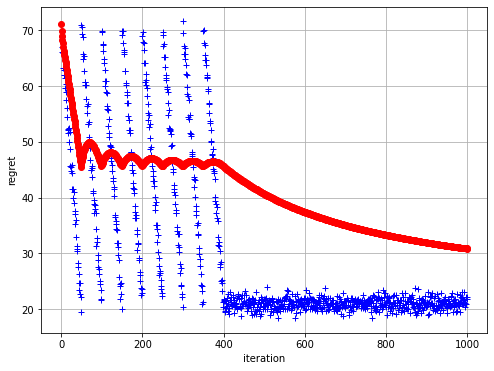

Optimal action: 50


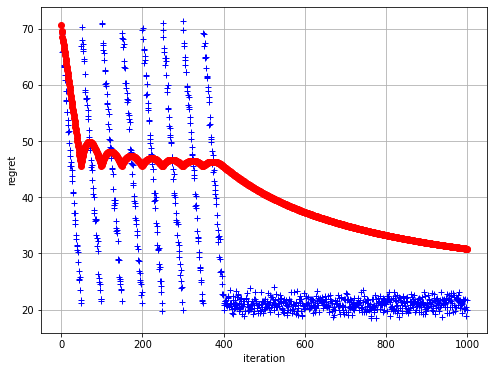

Optimal action: 50


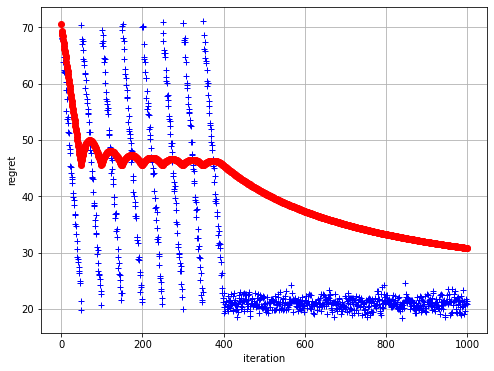

Optimal action: 50


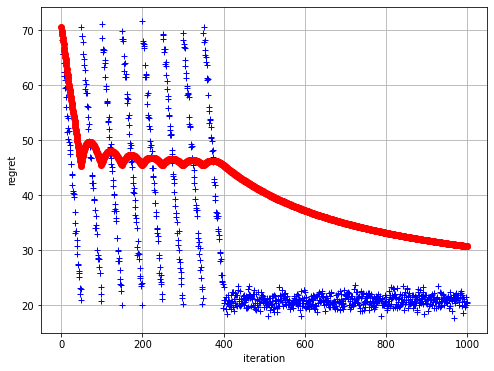

Optimal action: 50


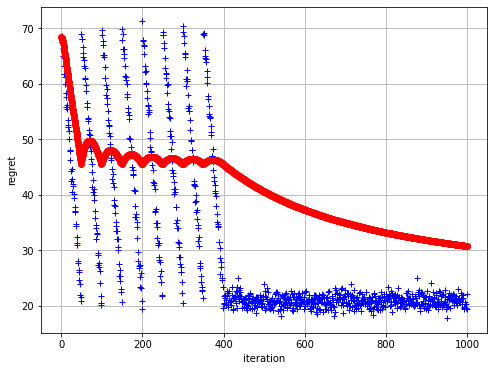

Optimal action: 50


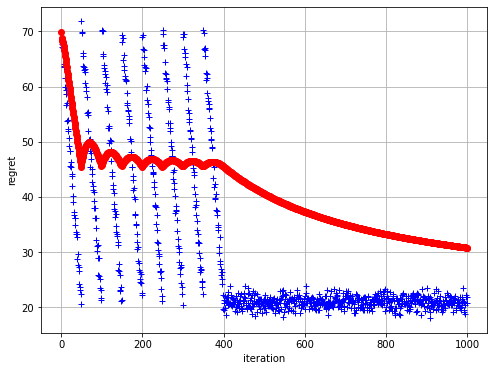

Optimal action: 50


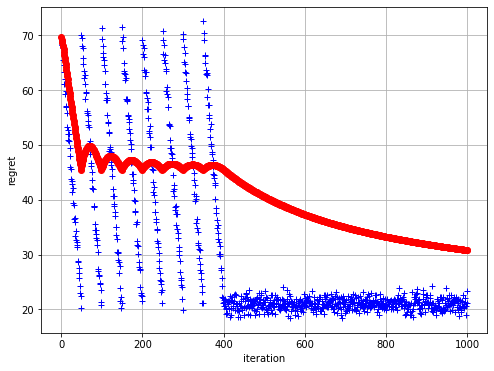

Optimal action: 50


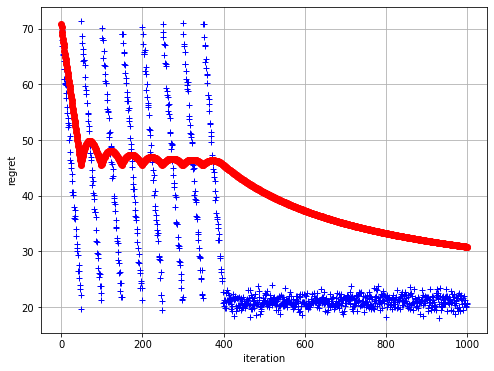

Optimal action: 50


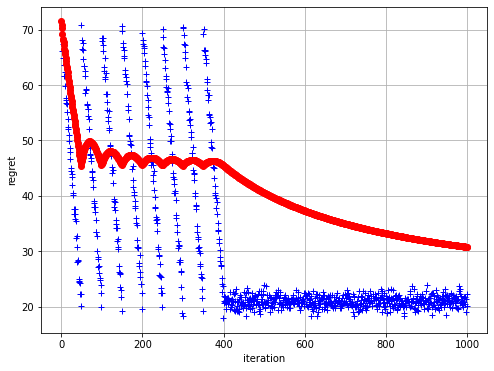

Optimal action: 50


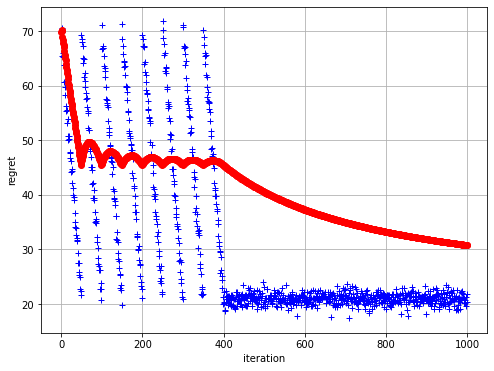

Optimal action: 50


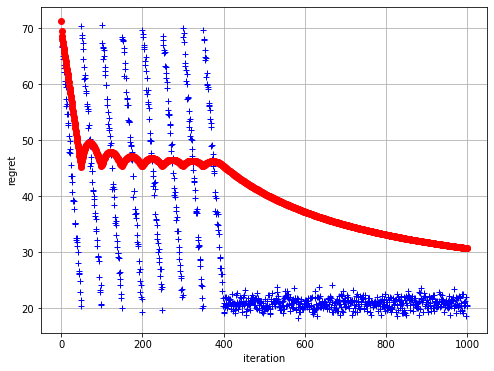

Optimal action: 50


In [350]:
# Try it with fifty arms and small differences among the mean values
# What are the required number of rounds to find the best action?

# each arm will have a different mean
# run the agorithm 20 times
for i in range(20):
  list_of_arms = []
  for i in range(50):
    list_of_arms.append(430+i)
  experiment_etc(k=50, mu=list_of_arms, m=8, rounds=1000)

With a differnce of 1 and 50 arms the algorithm needs to explore each arm atleast 8 times to get consistant results. This means a total of 400 rounds are to be spent on exploration to commit to the best arm. 

# UCB use-cases

#### Difference of 1 with 2 arms

Note: If i have 2 arms, then first arm is '0' and second arm is '1' (index starts at 0).

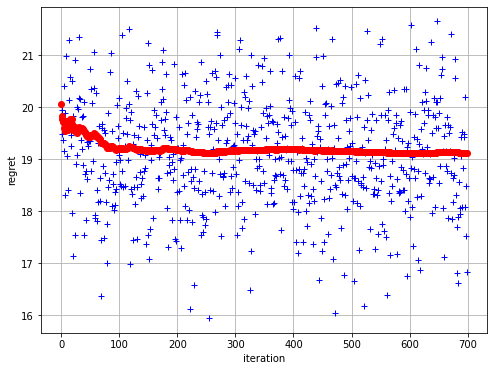

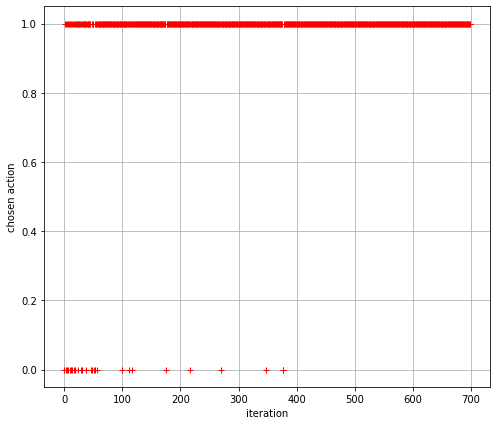

In [351]:
############## delta = 0.1 ##############

# Try it with two arms and small difference between the mean values
# What are the required number of rounds to find the best action?
# How the result changes with delta? 
experiment_ucb(k=2, mu=[480, 481], delta=0.1, rounds=700)

With a small difference in means and **delta=0.1**, the agorithm kept on giving the bad arm(arm 0) a chance to prove it self as it kept on exploiting the good arm more. It's difficult to count the number of rounds it took the algorthm to determine the best arm as its the nature of the algorithm to exploit the unexplored arms and more importantly the difference in the means is small which can have significant effect on exploration and exploitation trade-off. But i can see that exploitation of arm 0 was comparatively higher in the beginning and gradually reduced over time. 

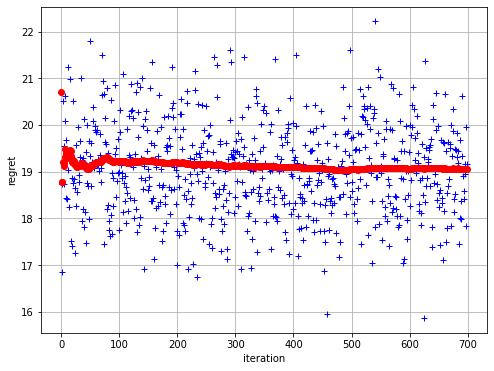

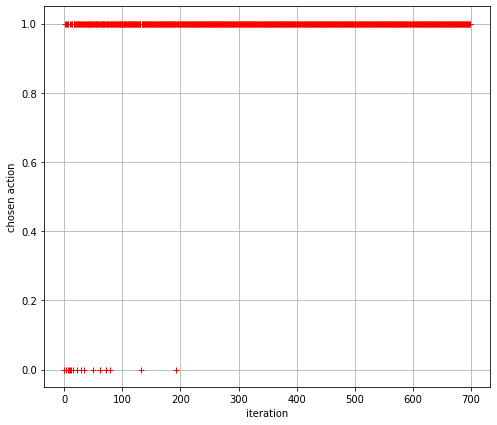

In [361]:
############## delta = 0.9 ##############

# Try it with two arms and small difference between the mean values
# What are the required number of rounds to find the best action?
# How the result changes with delta? 
experiment_ucb(k=2, mu=[480, 481], delta=0.9, rounds=700)

With the **same** small difference in means but **delta=0.9**, the agorithm did not give the bad arm (arm 0) many chances to prove it self as often as it did with delta=0.1. The effect of delta is that as it increases a smaller value is added to the average rewards which makes it less probable to pick the unexplored arms even if we spend many rounds on exploiting the best arm.

#### Difference of 10 with 2 arms

DELTA = 0.1


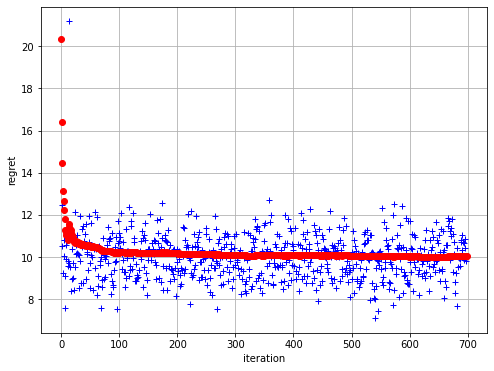

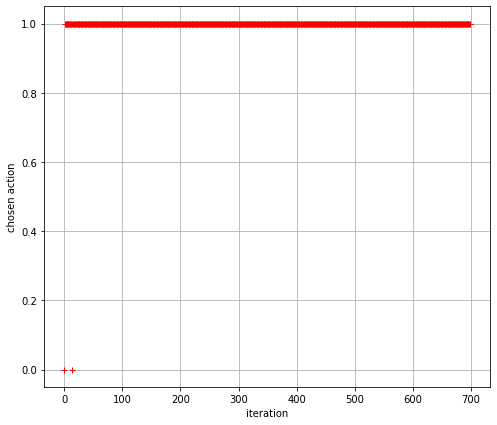

DELTA = 0.9


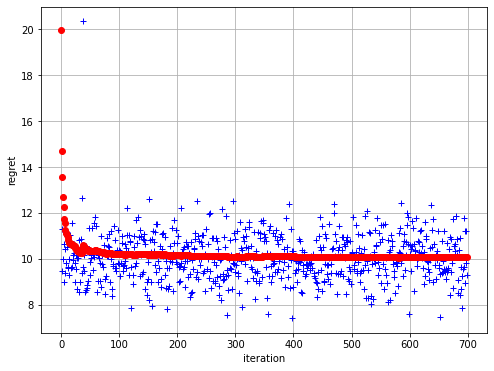

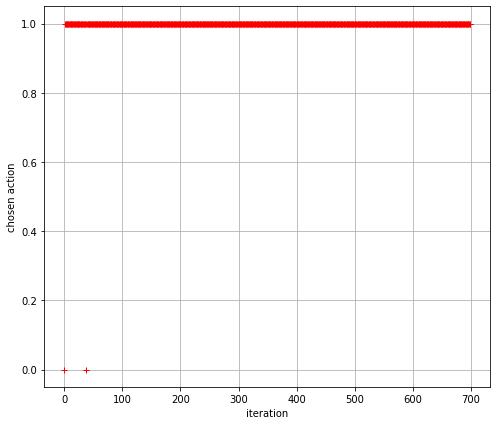

In [353]:
# Try it with two arms and big difference between the mean values
# What are the required number of rounds to find the best action?
# How the result changes with delta? 

delta = [0.1, 0.9]

for d in delta:
  print('DELTA = '+ str(d))
  experiment_ucb(k=2, mu=[480, 490], delta=d, rounds=700)

With a big differnece the value of delta wont have much impact on how many times the algorithm explores the unexplored arms as average rewards are already very high for the best arm.  With delta=0.1, the algorithm qucikly explored the bad arm in the begining, whereas, with delta=0.9 it took about 95 rounds for the algorithm to explore the unexplored arm. Overall each arm will be given atleast a single chance to be explored as we begin with equal rewards in the begining. 

Even though algorithm spends too many rounds on exploiting the best arm (reducing the UCB term) still it won't explore the arm with poor mean as often as with the bandit that has arms have small differences in means. 

#### Difference of 1 with 5 arms

DELTA = 0.1


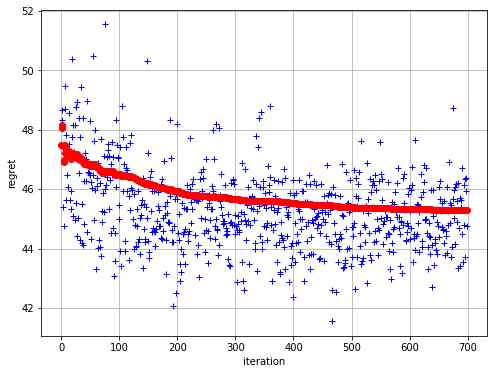

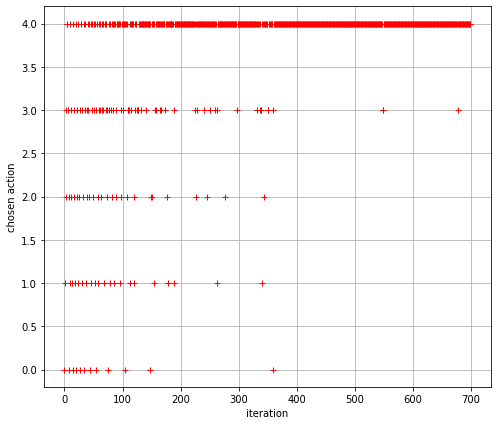

DELTA = 0.9


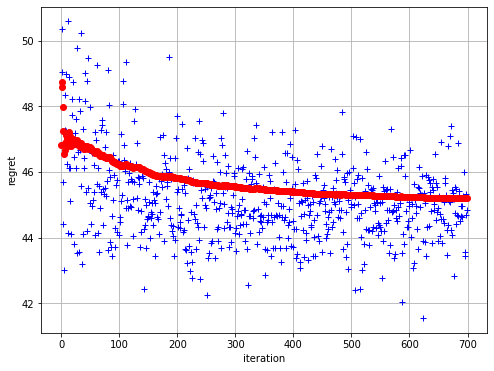

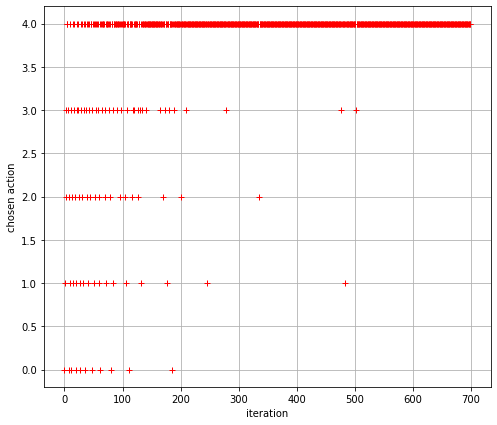

In [354]:
# Try it with five arms and small differences among the mean values
# What are the required number of rounds to find the best action?
# How the result changes with delta? 
delta = [0.1, 0.9]

for d in delta:
  print('DELTA = '+ str(d))
  experiment_ucb(k=5, mu=[451, 452, 453, 454, 455], delta=d, rounds=700)

With small differences, bad arms are given more chances to prove themselves as the number of rounds spent on exploiting best arms increases. As the value of delta increases, small values are added to the average means as compared to when delta is large. When delta=0.1, more chances are given to unexplored arms especially the arms with means close to optimal reward.

#### Difference of 1 with 50 arms

DELTA = 0.1


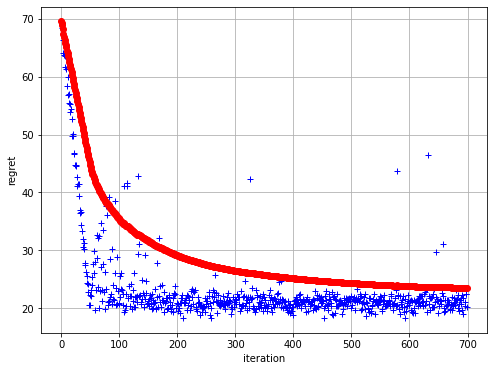

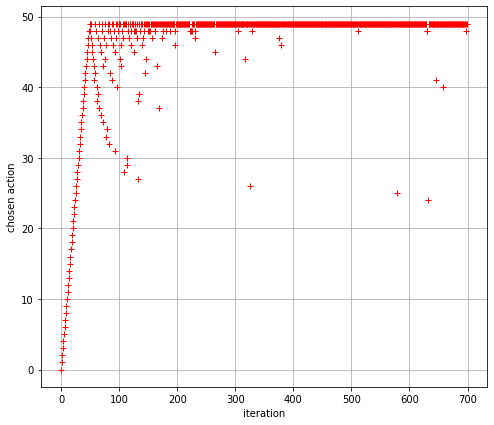

DELTA = 0.9


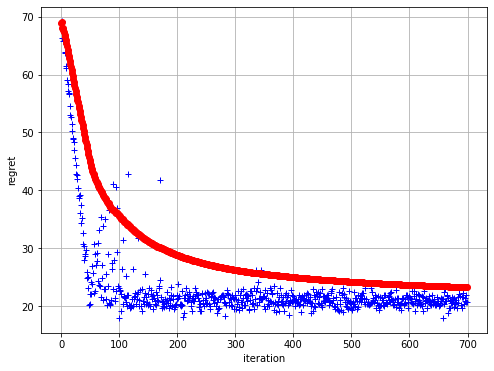

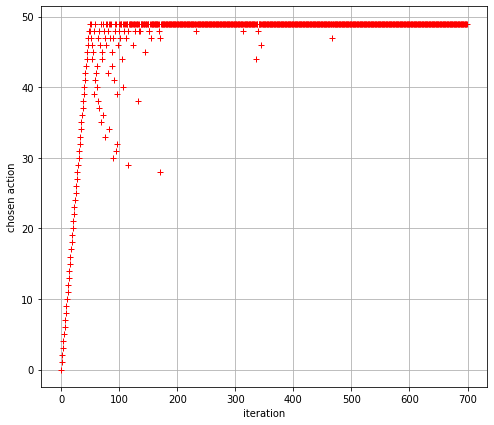

In [355]:
# Try it with fifty arms and small differences among the mean values
# What are the required number of rounds to find the best action?
# How the result changes with delta?

delta = [0.1, 0.9]
list_of_arms = []
for d in delta:
  print('DELTA = '+ str(d))
  for i in range(50):
    list_of_arms.append(430+i)
  experiment_ucb(k=50, mu=list_of_arms, delta=d, rounds=700)

With small differences, again I see that algorithm gives more chances to bad arms especially the ones which had mean close to the best arm. With Delta=0.1, more chances were given to the unexplored arms as compared to when delta=0.9